This example shows how to use a `GridInterpolationKernel` module on an `ExactGP` model. This module is designed for
- When you want to use exact inference (e.g. for regression)
- Useful when inputs are just one-dimensional 

Function to be modeled is  y=sin(4*pi*x)

GridInterpolationKernel exploits the regular grid structure of linspace for Toeplitz covariances

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

# Make plots inline
%matplotlib inline

In [2]:
# Training points are in [0,1] every 1/999
train_x = Variable(torch.linspace(0, 1, 1000))
# Function to model is sin(4*pi*x)
# Gaussian noise from N(0,0.04)
train_y = Variable(torch.sin(train_x.data * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [3]:
# We use exact GP inference for regression
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        # Put a grid interpolation kernel over the RBF kernel
        self.base_covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.covar_module = GridInterpolationKernel(self.base_covar_module, grid_size=400,
                                                            grid_bounds=[(0, 1)])
        # Register kernel lengthscale as parameter
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)

# The likelihood output is a Gaussian with predictive mean and variance
likelihood = GaussianLikelihood()
# Initialize our model
model = GPRegressionModel(train_x.data, train_y.data, likelihood)

In [4]:
# Optimize the model
model.train()
likelihood.train()

# Adam optimizer on both the model and likelihood parametres
optimizer = optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)
optimizer.n_iter = 0
training_iterations = 30
for i in range(training_iterations):
    # Zero backprop gradients
    optimizer.zero_grad()
    # Get output from model
    output = model(train_x)
    # Calc loss and backprop derivatives
    loss = -model.marginal_log_likelihood(likelihood, output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.data[0]))
    optimizer.step()

Iter 1/30 - Loss: 1.151
Iter 2/30 - Loss: 1.094
Iter 3/30 - Loss: 1.041
Iter 4/30 - Loss: 0.999
Iter 5/30 - Loss: 0.965
Iter 6/30 - Loss: 0.945
Iter 7/30 - Loss: 0.929
Iter 8/30 - Loss: 0.910
Iter 9/30 - Loss: 0.887
Iter 10/30 - Loss: 0.862
Iter 11/30 - Loss: 0.811
Iter 12/30 - Loss: 0.747
Iter 13/30 - Loss: 0.664
Iter 14/30 - Loss: 0.554
Iter 15/30 - Loss: 0.434
Iter 16/30 - Loss: 0.310
Iter 17/30 - Loss: 0.208
Iter 18/30 - Loss: 0.105
Iter 19/30 - Loss: 0.019
Iter 20/30 - Loss: -0.066
Iter 21/30 - Loss: -0.107
Iter 22/30 - Loss: -0.136
Iter 23/30 - Loss: -0.138
Iter 24/30 - Loss: -0.127
Iter 25/30 - Loss: -0.120
Iter 26/30 - Loss: -0.101
Iter 27/30 - Loss: -0.111
Iter 28/30 - Loss: -0.125
Iter 29/30 - Loss: -0.139
Iter 30/30 - Loss: -0.139


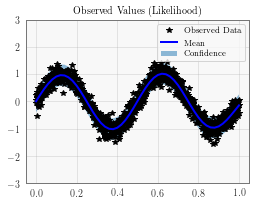

In [5]:
# Put model & likelihood into eval mode
model.eval()
likelihood.eval()

# Initalize plot
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
# Test points every 0.02 in [0,1] inclusive
test_x = Variable(torch.linspace(0, 1, 51))

# To make the predictions as accurate as possible, we're going to use lots of iterations of Conjugate Gradients
# This ensures that the matrix solves are as accurate as possible
with gpytorch.settings.max_cg_iterations(100):
    observed_pred = likelihood(model(test_x))

# Define plotting function
def ax_plot(ax, rand_var, title):
    # Get lower and upper predictive bounds
    lower, upper = rand_var.confidence_region()
    # Plot the training data as black stars
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
    # Plot confidence bounds as lightly shaded region
    ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')